# Set up, packages and environment

All analyses were conducted in Python 3.10.9

Using primarily functions from NiMare v0.1.1, Nilearn v0.10.1 and the following packages:

pandas
numpy
os
pathlib
datetime 
matplotlib

In [46]:
# import required packages
import pandas as pd 
import numpy as np
import os
from pathlib import Path 
from nimare.correct import FWECorrector
from nimare.dataset import Dataset
from nimare.utils import get_resource_path
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
from nilearn.image import binarize_img
from nimare.dataset import Dataset
from nimare.correct import FDRCorrector
from nimare.generate import create_coordinate_dataset
from nimare.meta import ALE
from nimare.meta.cbma.mkda import MKDADensity
from nimare.meta.cbma import ALESubtraction

from nimare.io import convert_sleuth_to_dataset,convert_sleuth_to_dict
from nimare.diagnostics import FocusCounter
from nimare.diagnostics import Jackknife
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from datetime import datetime


### change into the directory you're working in:

Change this to match your computer:

In [3]:
# use os packages to change directories
os.chdir('C:\\Users\\jmerch\\Documents\\Meta\\GitHub')

# Coordinate-Based Meta-Analysis (CBMA)

Premade NiMare coordinate datasets used to conduct the CBMAs can be found in: ```./data/coordinate_datasets```

I will use the "ALL" dataset that includes all 108 studies used in our primary CBMA as an example to run through the steps: ```./data/coordinate_datasets/ALL_dset.pkl```

More info on and examples of running CBMA using NiMare can be found here: https://nimare.readthedocs.io/en/latest/index.html


In [47]:
# use Nimare's Dataset.load to load nimare dataset for All meta-analysis
Dset=Dataset.load("./data/coordinate_datasets/ALL_dset.pkl")
Dset

Dataset(108 experiments, space='ale_2mm')

## Activation Likelihood Estimation (ALE) 

We used the ALE algorithm for our CBMAs, and will focus on what is presented in Figure 3/Table 2 in the main text as an example.

For more info: 

https://nimare.readthedocs.io/en/latest/auto_examples/index.html

https://nimare.readthedocs.io/en/latest/auto_examples/02_meta-analyses/01_plot_cbma.html#sphx-glr-auto-examples-02-meta-analyses-01-plot-cbma-py

https://nimare.readthedocs.io/en/latest/auto_examples/02_meta-analyses/03_plot_kernel_transformers.html#sphx-glr-auto-examples-02-meta-analyses-03-plot-kernel-transformers-py

https://nimare.readthedocs.io/en/latest/auto_examples/02_meta-analyses/04_plot_estimators.html#sphx-glr-auto-examples-02-meta-analyses-04-plot-estimators-py


meta-fit



INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


correction



  0%|          | 0/100 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


Focus counter



INFO:nimare.diagnostics:10 clusters found


  0%|          | 0/108 [00:00<?, ?it/s]

Jackknife



INFO:nimare.diagnostics:10 clusters found


  0%|          | 0/108 [00:00<?, ?it/s]

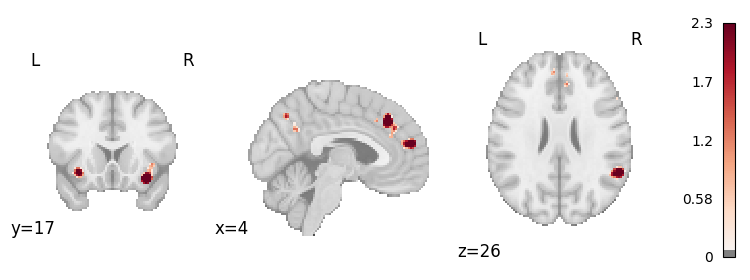

In [48]:
# set up ALE estimator  
meta = ALE()

# set-up FWE corrector using only 100 montecarlo iterations for demonstrations, but should use 1,000+ iterations
# Note: change n_cores to the number of CPU cores you can afford for this analysis
corr = FWECorrector(method="montecarlo", n_iters=100,n_cores=10)

# start meta fit and correction
print('meta-fit')
print("")
results = meta.fit(Dset)

# corrected results. This will give determine FWE corrected minimum cluster-size for the final results based on montecarlo iterations. 
# each iteration maintains the number and cluster sizes as each studies modeled activation map, but spatially randomizes the location. 
# the largest cluster size from aeach itertion is saved to determine the distribution of cluster-sizes.
print('correction')
print("")
cres = corr.transform(results)

# Focus counter (Supplemental Table 2)
counter = FocusCounter(
target_image="z_desc-size_level-cluster_corr-FWE_method-montecarlo",
voxel_thresh=None)

print('Focus counter')
print("")
cres = counter.transform(cres)

# Jackknife (Supplemental Table 3)
jackknife = Jackknife(
target_image="z_desc-size_level-cluster_corr-FWE_method-montecarlo",
voxel_thresh=None,n_cores=10) # Note: change n_cores to the number of CPU cores you can afford for this analysis

print('Jackknife')
print("")
cres = jackknife.transform(cres)

# Comment the lines below if you don't want to save the results and nii maps data to files:

# define output directory and make it if it doesn't exist
outdir = os.path.abspath("./example/all_cbma")
os.makedirs(outdir, exist_ok=True)

# save unthresholded results if desired
results.save_maps(output_dir=outdir, prefix="ALL_ALE_unthresholded", prefix_sep='_')
results.save(outdir + "ALL_ALE_unthresholdedResults.pkl")

# save thresholded results and tables
cres.save_maps(output_dir=outdir, prefix="ALL_ALE_FWE", prefix_sep='_')
cres.save(outdir + "ALL_ALE_FWEResults.pkl")
cres.save_tables(output_dir=outdir, prefix="ALL_ALE_FWE_Coordinates", prefix_sep='_')

# Use nilearns plot thresholded stat map to examine thresholded results. Note, because this was run with 100 iterations, it does not match the results in the text
plot_stat_map(
    cres.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    cut_coords=[4, 17, 26],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=0.1,
)

In [49]:
# you can view coordinates table for the significant clusters such as in Tables 2-4 of main text
cres.tables['z_desc-size_level-cluster_corr-FWE_method-montecarlo_tab-clust']

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,PositiveTail 1,52.0,-50.0,24.0,2.326348,10048
1,PositiveTail 2,50.0,18.0,26.0,2.326348,2616
2,PositiveTail 3,38.0,22.0,-8.0,2.326348,6472
3,PositiveTail 4,2.0,-58.0,38.0,2.326348,5368
4,PositiveTail 5,4.0,42.0,28.0,2.326348,12240
5,PositiveTail 6,-34.0,20.0,-8.0,2.326348,3536
6,PositiveTail 7,-32.0,-58.0,46.0,2.326348,1296
7,PositiveTail 8,-44.0,8.0,30.0,2.326348,1832
8,PositiveTail 9,-50.0,-58.0,30.0,2.326348,4032
9,PositiveTail 10,-26.0,-80.0,-34.0,0.806421,776


## Focus counter & Jacknife analysis

Focus counter (e.g., Supplemental Table 2) - This analysis characterizes the relative contribution of each experiment in a meta-analysis to the resulting clusters by counting the number of peaks from each experiment that fall within each significant cluster: 
https://nimare.readthedocs.io/en/latest/generated/nimare.diagnostics.FocusCounter.html#nimare.diagnostics.FocusCounter

Jackknife (e.g., Supplemental Table 3) - This analysis characterizes the relative contribution of each experiment in a meta-analysis to the resulting clusters by looping through experiments, calculating the Estimator’s summary statistic for all experiments except the target experiment, dividing the resulting test summary statistics by the summary statistics from the original meta-analysis, and finally averaging the resulting proportion values across all voxels in each cluster:
https://nimare.readthedocs.io/en/latest/generated/nimare.diagnostics.Jackknife.html#nimare.diagnostics.Jackknife

In [9]:
# you can also view focus counter table as in Supplemental Table 2
cres.tables['z_desc-size_level-cluster_corr-FWE_method-montecarlo_diag-FocusCounter_tab-counts']

,id,PositiveTail 1,PositiveTail 2,PositiveTail 3,PositiveTail 4,PositiveTail 5,PositiveTail 6,PositiveTail 7,PositiveTail 8,PositiveTail 9,PositiveTail 10
0,Abe_2019-1,4,0,0,1,1,0,0,0,2,1
1,Abu-Akel_2020-1,1,0,0,0,1,0,0,0,0,0
2,Alkire_2018-1,3,3,4,0,1,1,0,0,0,0
3,Anders_2015-1,0,0,0,0,2,0,0,0,0,0
4,Assaf_2013-1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
103,Yoshie_2016-1,0,0,0,0,0,0,0,0,0,0
104,Yoshioka_2021-1,16,8,21,12,16,8,4,2,7,3
105,Zimmermann_2019-1,1,0,0,0,0,0,0,0,0,0
106,deQuervain_2004-1,0,0,0,0,0,0,1,0,0,0


In [10]:
# you can also view jacknife table as in Supplemental Table 3
cres.tables['z_desc-size_level-cluster_corr-FWE_method-montecarlo_diag-Jackknife_tab-counts']

,id,PositiveTail 1,PositiveTail 2,PositiveTail 3,PositiveTail 4,PositiveTail 5,PositiveTail 6,PositiveTail 7,PositiveTail 8,PositiveTail 9,PositiveTail 10
0,Abe_2019-1,0.034691,0.0,0.0,0.008482,0.008843,0.0,0.0,0.000001,0.047242,0.105967
1,Abu-Akel_2020-1,0.010611,0.0,0.0,0.0,0.007298,0.0,0.0,0.0,0.0,0.0
2,Alkire_2018-1,0.021393,0.05416,0.03636,0.007668,0.013333,0.036918,0.000621,0.000002,0.010668,0.042637
3,Anders_2015-1,0.0,0.0,0.0,0.000088,0.010601,0.0,0.0,0.0,0.007406,0.0
4,Assaf_2013-1,0.012096,0.018686,0.000016,0.002756,0.004122,0.000153,0.0,0.0,0.000055,0.0
...,...,...,...,...,...,...,...,...,...,...,...
103,Yoshie_2016-1,0.000517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,Yoshioka_2021-1,0.079144,0.100215,0.101501,0.113963,0.071854,0.082162,0.102849,0.087169,0.080928,0.134429
105,Zimmermann_2019-1,0.011871,0.0,0.001513,0.0,0.00076,0.000836,0.0,0.000001,0.000182,0.0
106,deQuervain_2004-1,0.000227,0.0,0.0,0.000001,0.000452,0.0,0.055823,0.0,0.0,0.0


## Leave one (study) out cross-validation (LOOCV)

LOOCV (i.e., Supplemental Figure 1) - Was used to ensure that our resulting clusters could not be attributed to single or a few studies. We used similar parameters as  the primary All meta-analysis and conducted CBMA after leaving out one study, saved the thresholded ALE map, and repeated this process after leaving out each of the 108 studies. Thresholed ALE maps were binarized, averaged together, and multiplied by a 100 to spatially visualize the percentage of iterations showing significant covergence across the brain. 

CBMA was conducted using NiMare like above, and binarization and averaging were conducted using NiLearn and FSL maths. 


In [ ]:
# we'll reload the dataset and set up the ALE and corrector. This time we'll do 10 iterations
# per ALE for time
Dset=Dataset.load("./data/coordinate_datasets/ALL_dset.pkl")
meta = ALE()
corr = FWECorrector(method="montecarlo", n_iters=10, n_cores=10)

# define output directory and make it if it doesn't exist
out_dir = os.path.abspath("./example/loocv")
os.makedirs(out_dir, exist_ok=True)

# create vector of ones as annotation for the dataset that will be used to select all but one study
Ones=np.ones(len(Dset.ids))
# though nimare datasets are meant to immutable, annotations can be added
Dset.annotations['all']=Ones

# loop through each study
for x in range(len(Ones)):

    # create new, curent studies vector by copying Ones, zero out current study, and modify annotations
    cur=Ones
    cur[x]=0
    Dset.annotations['all']=cur

    # use nimare function get_studies_by_label to create index from annotations, 
    # and create a new current dataset after leaving out study
    cur_idx = Dset.get_studies_by_label("all")
    dset_cur = Dset.slice(cur_idx)

    # run ALE and corrector
    results = meta.fit(dset_cur)
    cres = corr.transform(results)

    # create file name prefix for current iteration
    cur_file=out_dir + '/iter_' + str(f'{x:03d}') + '.nii.gz'

    # use nilearn to binarize image and save 
    binimage=binarize_img(cres.get_map("z_desc-size_level-cluster_corr-FWE_method-montecarlo"))
    binimage.to_filename(cur_file) # save binarized thresholded image


After all LOOCV iterations finished an produced a binarized map, we used ```fslmerge``` and ```fslmaths``` function in a bash environment. I'm sure there are ways to keep this in the python/nilearn ecosystem, but we went with what we knew. If you are following along above, this is how to implement what we did: 

```
# merge images into 4d
fslmerge -a ./example/loocv/MergedBinImages.nii.gz $(find ./example/loocv -name iter_*.nii.gz | xargs ls)

# get mean and multiply by 100 to convert to percent
fslmaths ./example/loocv/MergedBinImages.nii.gz -Tmean -mul 100 ./example/loocv/ConjMergedPercent.nii.gz
```


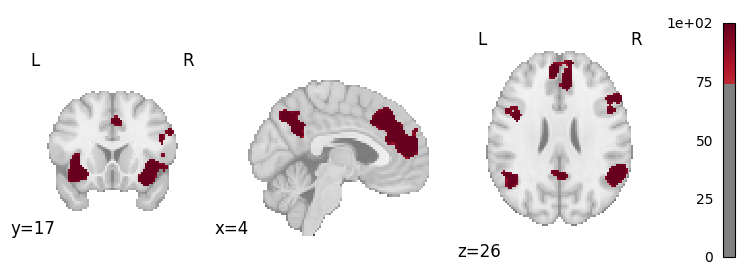

In [33]:
# Use nilearns plot stat map to examine loocv from results folder thresholded at 75%:
plot_stat_map(
    "./results/loocv/ConjMergedPercent.nii.gz",
    cut_coords=[4, 17, 26],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=75,
)

## Alternatives to ALE CBMA

NiMare offers easy implementation of another popular CBMA algorithm, Multilevel Kernel Density Analysis (MKDA). We found similar results using this approach

meta-fit



INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.mkda.MKDADensity.correct_fwe_montecarlo.


correction



  0%|          | 0/100 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


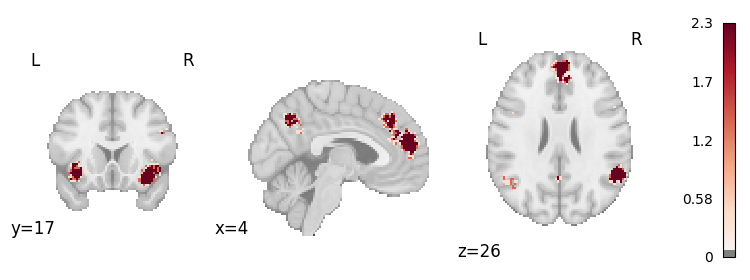

In [34]:
# set up ALE estimator  
meta = MKDADensity()

# set-up FWE corrector using only 100 montecarlo iterations for demonstrations, but should use 1,000+ iterations
corr = FWECorrector(method="montecarlo", n_iters=100)

# start meta fit and correction
print('meta-fit')
print("")
results = meta.fit(Dset)

# corrected results. 
print('correction')
print("")
cres = corr.transform(results)

# Use nilearns plot thresholded stat map to examine thresholded results. Note, because this was run with 100 iterations, it does not match the results in the text
plot_stat_map(
    cres.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    cut_coords=[4, 17, 26],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=0.1,
)

# Run your own modified CBMA

In this section, we'll go over how to create and run your own CBMA. This is meant to serve as a way for researchers to build off these findings, re-run analyses after re-categorizing contrasts (if the reader disagrees with the authors anotation), and/or evaluate what we have done. 

## Examine raw data files

The Nimare coordinate datasets above were created using the files that you can find the data folder:  ```./data```

This includes: 

**StudyMetaData.csv** which contains basic data about each of the 108 studies, such sample size, age etc. 

**ContrastsAnnotations.csv** has more detailed information about each of the 191 contrasts in the dataset, including the columns for each of the sub-CBMAs we ran (Social Engagement, Interaction, Initiating, Responding) as well as others not presented in the text. You can edit this file if you want to create your own sub-analysis.

**CoordinateData_MNI.csv** contains the MNI coordinates for all 2,659 foci across the 191 contrasts across 108 studies in our dataset. Any study reporting coordinates in Talairach space were converted to MNI


In [40]:
MetaData=pd.read_csv("./data/StudyMetaData.csv")
MetaData

,ShortForm,Study,SampleSize,PercentFemale,AverageAge,SDAge,AgeRange,Space,NumOfContrasts,study_id,Tags
0,Abe_2019,Study1,38,47.36842105,NaN,NaN,19-27,MNI,1,Abe_2019,Joint Action; Hyperscanning; Grip Force; Hand ...
1,Abu-Akel_2020,Study1,24,79.17%,21.21000,4.210000,NaN,MNI,1,Abu-Akel_2020,Human vs Computer; Rock-Paper-Scissors;
2,Alkire_2018,Study1,28,50%,10.41000,1.460000,8.18-12.98,MNI,3,Alkire_2018,Social Interaction; Human vs Computer; Chat;
3,Anders_2015,Study1,18,100,22.10000,NaN,19-28,MNI,2,Anders_2015,Emotion; Human vs Computer; METHOD: MVPA Class...
4,Assaf_2013,Study1,27,22.22,17.44815,3.455556,NaN,MNI,1,Assaf_2013,Competitive game; Human vs Computer; Dominos; ...
...,...,...,...,...,...,...,...,...,...,...,...
103,Xie_2020,Study1,36,44.4,27.44000,4.980000,18-45,MNI,1,Xie_2020,Hyperscanning; collaborative interaction; Pict...
104,Yoo_2020,Study1,19,47.37%,25.68000,3.580000,19-31,MNI,1,Yoo_2020,Doubt game; Lying; Emotions; Anxiety; Deception
105,Yoshie_2016,Study1,21,52.380952,25.50000,6.100000,NaN,MNI,2,Yoshie_2016,Social Observation; Hand grip;
106,Yoshioka_2021,Study1,44,54.55%,21.27000,2.380000,NaN,MNI,7,Yoshioka_2021,Hyperscanning; Shared attention; Joint Attenti...


In [41]:
ContrastTracker=pd.read_csv("./data/ContrastsAnnotations.csv")
ContrastTracker

,id,ContrastNameSimple,study_id,contrast_id,Paper,Author,Year,Title,Journal,Collection,...,Action,SocialEngagement,Interaction,Initiating,Responding,SocialObs,KnownPartner,HyperScanning,SocialVsNon_Symbolic,SocVsSoc_Symbolic
0,Abe_2019-1,Perform Joint > Perform Solo,Abe_2019,1,"Abe, M. O., Koike, T., Okazaki, S., Sugawara, ...",Abe,2019,Neural correlates of online cooperation during...,NeuroImage,Neural,...,1,1,0,0,0,0,0,0,0,0
1,Abu-Akel_2020-1,Human > Computer,Abu-Akel_2020,1,"Abu-Akel, A. M., Apperly, I. A., Wood, S. J., ...",Abu-Akel,2020,Re-imaging the intentional stance.,Proceedings of the Royal Society B: Biological...,ExclusionTerms,...,0,1,0,0,0,0,0,0,0,0
2,Alkire_2018-1,Human > Computer,Alkire_2018,1,"Alkire, D., Levitas, D., Warnell, K. R., & Red...",Alkire,2018,Social interaction recruits mentalizing and re...,Human Brain Mapping,SocIntx,...,0,1,0,0,1,0,0,0,0,0
3,Alkire_2018-2,Human > Computer (non-mental),Alkire_2018,2,"Alkire, D., Levitas, D., Warnell, K. R., & Red...",Alkire,2018,Social interaction recruits mentalizing and re...,Human Brain Mapping,SocIntx,...,0,0,0,0,1,0,0,0,0,0
4,Alkire_2018-3,Human > Computer (mental),Alkire_2018,3,"Alkire, D., Levitas, D., Warnell, K. R., & Red...",Alkire,2018,Social interaction recruits mentalizing and re...,Human Brain Mapping,SocIntx,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Yoshioka_2021-4,Initiate Joint Attention > control (spatial),Yoshioka_2021,4,"Yoshioka, A., Tanabe, H. C., Sumiya, M., Nakag...",Yoshioka,2021,Neural substrates of shared visual experiences...,Social Cognitive and Affective Neuroscience,SocExcluding,...,0,1,0,1,0,0,0,1,1,0
187,Yoshioka_2021-5,Respond Joint Attention > control (spatial),Yoshioka_2021,5,"Yoshioka, A., Tanabe, H. C., Sumiya, M., Nakag...",Yoshioka,2021,Neural substrates of shared visual experiences...,Social Cognitive and Affective Neuroscience,SocExcluding,...,0,1,0,0,1,0,0,1,1,0
188,Yoshioka_2021-6,Initiate Joint Attention > control (feature),Yoshioka_2021,6,"Yoshioka, A., Tanabe, H. C., Sumiya, M., Nakag...",Yoshioka,2021,Neural substrates of shared visual experiences...,Social Cognitive and Affective Neuroscience,SocExcluding,...,0,1,0,1,0,0,0,1,1,0
189,Yoshioka_2021-7,Respond Joint Attention > control (feature),Yoshioka_2021,7,"Yoshioka, A., Tanabe, H. C., Sumiya, M., Nakag...",Yoshioka,2021,Neural substrates of shared visual experiences...,Social Cognitive and Affective Neuroscience,SocExcluding,...,0,1,0,0,1,0,0,1,1,0


In [42]:
CoordinateData=pd.read_csv("./data/CoordinateData_MNI.csv")
CoordinateData

,study_id,Space,contrast_id,X,Y,Z,id
0,Abe_2019,MNI,1,-26,-82,-34,Abe_2019-1
1,Abe_2019,MNI,1,-36,-42,-36,Abe_2019-1
2,Abe_2019,MNI,1,-52,-50,22,Abe_2019-1
3,Abe_2019,MNI,1,-60,-50,36,Abe_2019-1
4,Abe_2019,MNI,1,-54,-60,38,Abe_2019-1
...,...,...,...,...,...,...,...
2654,Zimmermann_2019,MNI,1,54,-34,26,Zimmermann_2019-1
2655,Zimmermann_2019,MNI,1,-48,-64,8,Zimmermann_2019-1
2656,Zimmermann_2019,MNI,1,45,11,-1,Zimmermann_2019-1
2657,Zimmermann_2019,MNI,1,39,8,5,Zimmermann_2019-1


## Modifying the contrast annotations file for new analyses

The easiest way to way to set up your own CBMA is to edit the Contrast Annotations file, which has binary columns indicating whether a contrast qualifies for a sub-analysis (1=yes ; 0=no). You can edit existing columns (e.g., Social engagement) if you don't agree with the authors' anotations and/or create new columns that select studies based on a new topic (as long as it is binary 1s and 0s). This file was used to create the coordinate datasets we used to run our CBMAs. 

Because Nimare coordinate dataset objects are meant to be immutable, we create GingerALE/Sleuth style text files and used Nimare's ```convert_sleuth_to_dataset``` function to create the dataset for CBMA. We first set up a function that takes in the modified version of the MetaData, ContrastTracker, and CoordinateData files read in above and creats a text file, then use that to create the Nimare dataset object

In [43]:
#  function to make the ALE text files by study
def make_ale_txt_bystudy(outfile="./example/NewDataset.txt",ContrastTracker=ContrastTracker,CoordinateData=CoordinateData,MetaData=MetaData):

    # get all unique studies
    Studies = ContrastTracker['study_id'].unique()
    
    # if the outfile doesn't exist, create it
    if not os.path.exists(outfile):
        #print('out file doesnt exist, creating it now')
        open(outfile,'w').close()
    else:
        os.remove(outfile)
        open(outfile,'w').close()
    
    # loop through them
    for i,x in enumerate(Studies):
        
        # get index separate out the current study
        coorIndx=CoordinateData['study_id']==x
        tmp=CoordinateData.loc[coorIndx]
        Reference='//Reference=MNI'
        Label='//' + tmp.iloc[0,0] + ':1'
        coordinates=tmp.iloc[:,3:6].to_string(header=False,index=False)
        
        # get sample size from meta data df
        sampleIndx=MetaData['study_id']==x
        tmp2=MetaData.loc[sampleIndx]
        Sample='//Subjects=' + str(int(tmp2['SampleSize']))
        
        # use the open command to write to file
        with open(outfile, 'a') as f:
            if i==0:
                f.write(Reference)
                f.write('\n')
            
            f.write(Label)
            f.write('\n')
            f.write(Sample)
            f.write('\n')
            f.write(coordinates)
            f.write('\n')
            f.write('\n')
            

In [45]:
# using the function above, we can now re-make the social engagement dataset text file by creating a temporary contrast file with the right contrasts
# but you can do this using any new column/annotation you created too
CurContrasts=ContrastTracker[ContrastTracker['SocialEngagement']==1]

# Use the function we create to write the ginger ale text file
make_ale_txt_bystudy(outfile="./example/SocialEngagementDataset.txt",ContrastTracker=CurContrasts,CoordinateData=CoordinateData,MetaData=MetaData)

# Now use the convert_sleuth_to_dataset function to 
NewDset=convert_sleuth_to_dataset("./example/SocialEngagementDataset.txt")

# save the nimare dataset as pkl file if desired
NewDset.save("./example/SocialEngagementDataset.pkl")

NewDset
# Now you can use this dataset file to run any of the analyses covered in the previous sections!

## Premade NiMare coordinate datasets we used in the CBMAs we ran

The contrast tracker contains columns for each of the CBMAs we report in the paper (e.g., Social engagement), as well as others we did not. As a point of comparison and transparency/openness, we also provide the premade NiMare coordinate datasets we used in the CBMAs we ran:

"All" overarching CBMA of 108 studies - ```./data/coordinate_datasets/ALL_dset.pkl```

"Social Engagement" CBMA of contrasts using non-social, but interactive control condition - ```./data/coordinate_datasets/SocialEngagement_dset.pkl```

"Interaction" CBMA of contrasts using social, but non-interactive control condition - ```./data/coordinate_datasets/Interaction_dset.pkl```

"Human vs Computer" CBMA of contrasts using interaction with computer/robot as control condition - ```./data/coordinate_datasets/HvC_dset.pkl```

"Initiating" CBMA of contrasts wherein participants initiates interactive behavior - ```./data/coordinate_datasets/Initiating_dset.pkl```

"Responding" CBMA of contrasts wherein participants respond to interactive behavior - ```./data/coordinate_datasets/Responding_dset.pkl```

# Meta-analytic Coactivation Modeling (MACM)



In [42]:
Dset1=convert_sleuth_to_dataset("C:\\Users\\jmerch\\Documents\\Meta\\NiMare\\ALE4\\GingerALEtxt\\ALL_byStudy.txt")
Dset1

Dataset(108 experiments, space='ale_2mm')

In [43]:
Dset1.coordinates

,id,study_id,contrast_id,x,y,z,space
0,Abe_2019-1,Abe_2019,1,-26.0,-82.0,-34.0,ale_2mm
18,Abe_2019-1,Abe_2019,1,12.0,28.0,58.0,ale_2mm
17,Abe_2019-1,Abe_2019,1,-18.0,14.0,58.0,ale_2mm
16,Abe_2019-1,Abe_2019,1,28.0,32.0,44.0,ale_2mm
15,Abe_2019-1,Abe_2019,1,-36.0,10.0,50.0,ale_2mm
...,...,...,...,...,...,...,...
431,deQuervain_2004-1,deQuervain_2004,1,6.0,22.0,4.0,ale_2mm
426,deQuervain_2004-1,deQuervain_2004,1,58.0,-38.0,-32.0,ale_2mm
424,deQuervain_2004-1,deQuervain_2004,1,6.0,24.0,2.0,ale_2mm
1792,vandenBos_2007-1,vandenBos_2007,1,60.0,-3.0,-32.0,ale_2mm


In [9]:
Dset1=Dataset.load("C:\\Users\\jmerch\\Documents\\Meta\\NiMare\\ALE4\\ALL\\ALL_dset.pkl")
Dset1

Dataset(108 experiments, space='ale_2mm')

meta-fit



INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


correction



  0%|          | 0/100 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


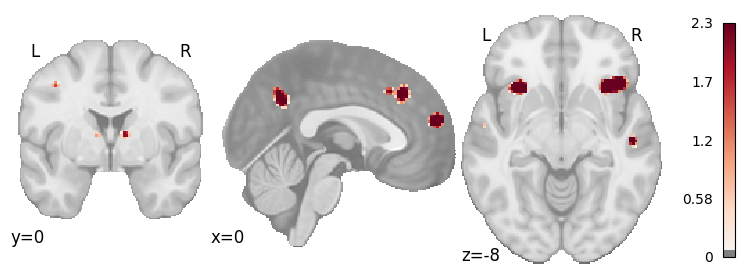

In [11]:
# set up ALE estimator and correction
meta = ALE(n_cores=10)
corr = FWECorrector(method="montecarlo", n_iters=100, n_cores=10)
# start meta fit and correction
print('meta-fit')
print("")
results = meta.fit(Dset)

print('correction')
print("")
cres = corr.transform(results)

plot_stat_map(
    cres.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=0.1,
)



meta-fit



INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


correction



  0%|          | 0/100 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


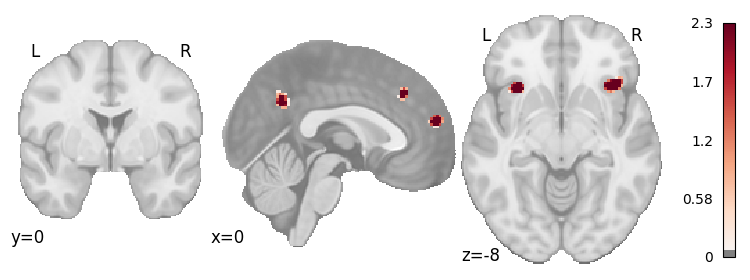

In [12]:
# set up ALE estimator and correction
meta1 = ALE(n_cores=10)
corr1 = FWECorrector(method="montecarlo", n_iters=100, n_cores=10)
# start meta fit and correction
print('meta-fit')
print("")
results1 = meta.fit(Dset1)

print('correction')
print("")
cres1 = corr1.transform(results1)

plot_stat_map(
    cres1.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=0.1,
)


# Getting neurosynth 

In [ ]:
# This was taken from the NiMare documentation:
# https://nimare.readthedocs.io/en/latest/auto_examples/index.html
# https://nimare.readthedocs.io/en/latest/auto_examples/01_datasets/02_download_neurosynth.html#sphx-glr-auto-examples-01-datasets-02-download-neurosynth-py

# import the necessary packages
import os
from pprint import pprint
import Bio
from nimare.extract import download_abstracts, fetch_neuroquery, fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset

# create output file
out_dir = os.path.abspath("./example/coordinate_datasets")
os.makedirs(out_dir, exist_ok=True)

files = fetch_neurosynth(
    data_dir=out_dir,
    version="7",
    overwrite=False,
    source="abstract",
    vocab="terms",
)
# Note that the files are saved to a new folder within "out_dir" named "neurosynth".
pprint(files)
neurosynth_db = files[0]

# Convert Neurosynth database to NiMARE dataset file
neurosynth_dset = convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)
neurosynth_dset.save(os.path.join(out_dir, "neurosynth_dataset.pkl.gz"))
print(neurosynth_dset)

